* IDR optimal peak set: 129442 peaks "/srv/scratch/annashch/dmso/raw_data/"
* input: fc signal strength for the pooled pseudo replicates over the IDR peaks 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
data=data.frame(read.table('/srv/scratch/annashch/dmso/atacseq_merged.txt',header=TRUE,sep='\t'))
chrom=data$Chrom
start_pos=data$Start
end_pos=data$End
unique_names=paste(chrom,start_pos,end_pos,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL
rownames(data)=unique_names



In [3]:
head(data)

,atac_earlyG1_ld_control_pr1,atac_earlyG1_ld_control_pr2,atac_earlyG1_ld_treated_pr1,atac_earlyG1_ld_treated_pr2,atac_lateG1_ld_control_pr2,atac_lateG1_ld_control_pr1,atac_lateG1_ld_treated_pr1,atac_lateG1_ld_treated_pr2,atac_SG2M_ld_control_pr1,atac_SG2M_ld_control_pr2,atac_SG2M_ld_treated_pr1,atac_SG2M_ld_treated_pr2
chr1_9998_10674,1.86465,6.46552,4.96183,3.87931,4.17463,5.42702,4.95418,4.57309,17.72516,9.26543,13.20601,5.72260
chr1_237617_237891,8.85709,8.39093,11.01625,9.69431,8.34926,10.01912,7.24072,6.09745,7.65405,7.25120,7.04320,7.04320
chr1_521429_521681,4.19546,3.26314,7.49105,11.45691,6.26195,3.33971,1.00000,6.09745,2.81991,4.43129,1.00000,1.00000
chr1_713708_714679,21.35922,22.16495,2.81330,2.40964,3.72208,18.15754,20.00000,17.99545,17.10526,14.32927,4.60526,19.46108
chr1_762176_763226,6.99244,7.45860,10.57560,2.64390,4.12371,2.08732,1.52436,6.37899,2.01422,2.01422,2.16920,2.64120
chr1_780030_780369,8.51064,5.59395,3.08455,8.81301,5.42702,8.25853,3.81091,4.57309,6.84836,4.02845,1.76080,2.20100


In [4]:
batches=data.frame(read.table('/srv/scratch/annashch/dmso/atacseq_batches.txt',header=TRUE,sep='\t'))

In [5]:
head(batches)

Rep,Sample,Treatment,Timepoint
atac_earlyG1_ld_control_pr1,atac_earlyG1_ld_control,control,earlyG1
atac_earlyG1_ld_control_pr2,atac_earlyG1_ld_control,control,earlyG1
atac_earlyG1_ld_treated_pr1,atac_earlyG1_ld_treated,treated,earlyG1
atac_earlyG1_ld_treated_pr2,atac_earlyG1_ld_treated,treated,earlyG1
atac_lateG1_ld_control_pr1,atac_lateG1_ld_control,control,lateG1
atac_lateG1_ld_control_pr2,atac_lateG1_ld_control,control,lateG1


In [6]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = round(data),
                              colData = batches,
                              design = ~Timepoint + Timepoint:Treatment)


converting counts to integer mode


## Visualizations 

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


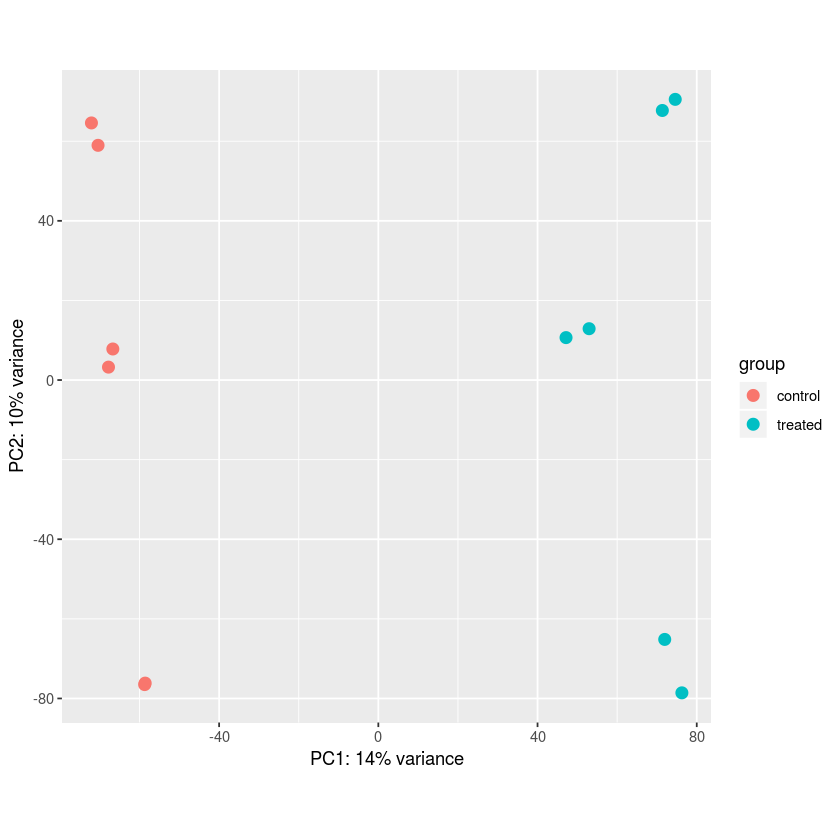

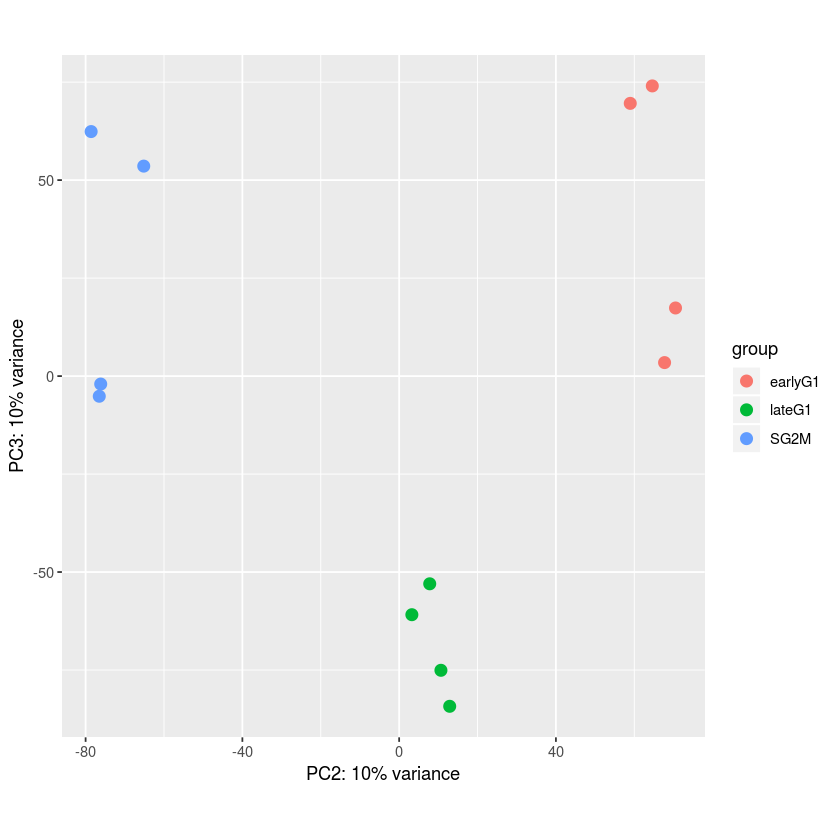

In [8]:
#PCA on vst-transformed data
vst_data=vst(dds)
source('plotPCA_custom.R')
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=nrow(data),returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("Timepoint"),ntop=nrow(data),returnData=FALSE,pcx=2,pcy=3)


In [9]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("HK.promoters.txt",header=TRUE,sep='\t')
hk_promoters=paste(hk_promoters$Chrom,hk_promoters$Start,hk_promoters$End,sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))


In [10]:
dds <- estimateSizeFactors(dds, controlGenes=hk_promoter_indices)


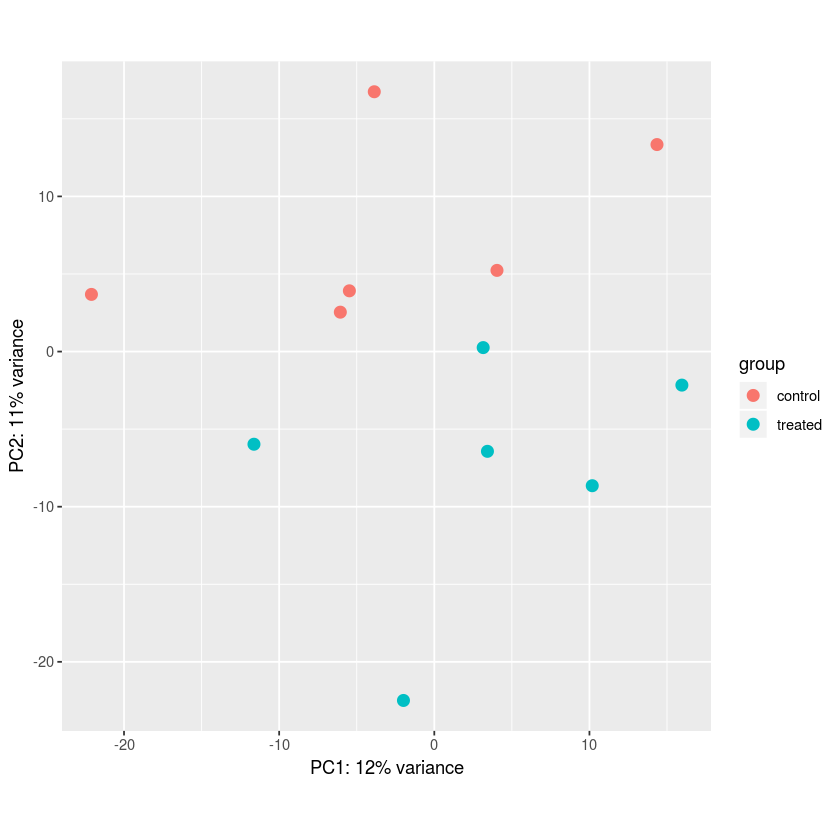

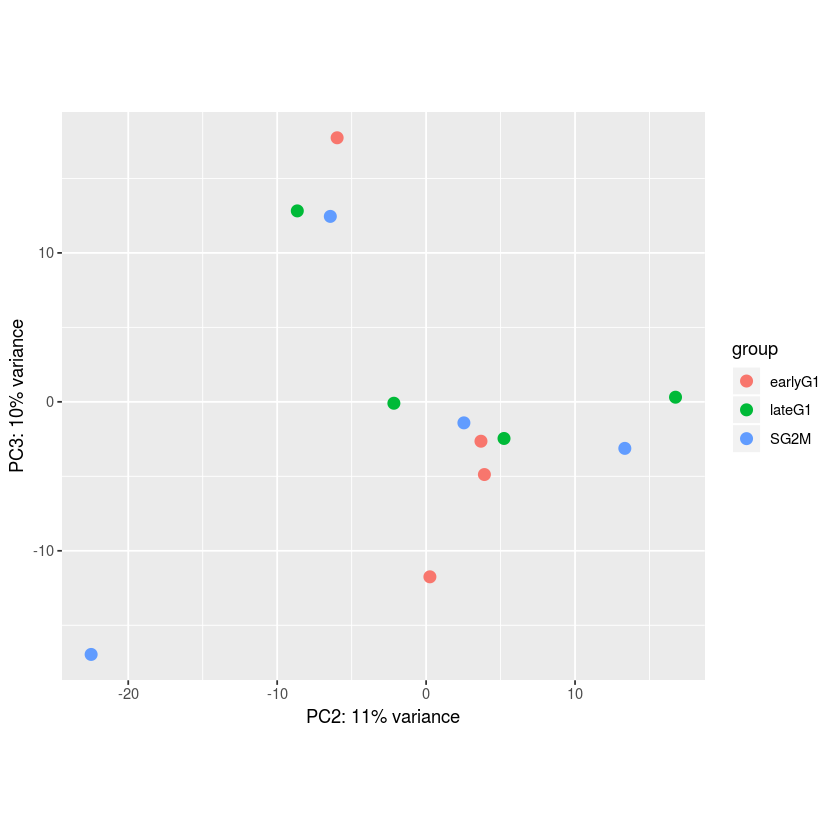

In [12]:
#PCA on vst-transformed data w/ custom sizeFactors
# shifted log of normalized counts
se <- SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
# the call to DESeqTransform() is needed to
# trigger our plotPCA method.
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("Timepoint"),pcx=2,pcy=3)


## Extract and store normalized counts for further analysis 

In [13]:
normcounts=counts(dds,normalized=TRUE)
write.table(normcounts,"normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)



## Differential Accessibility Operation

In [14]:
#Run the differential analysis
dds <- DESeq(dds,parallel = FALSE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


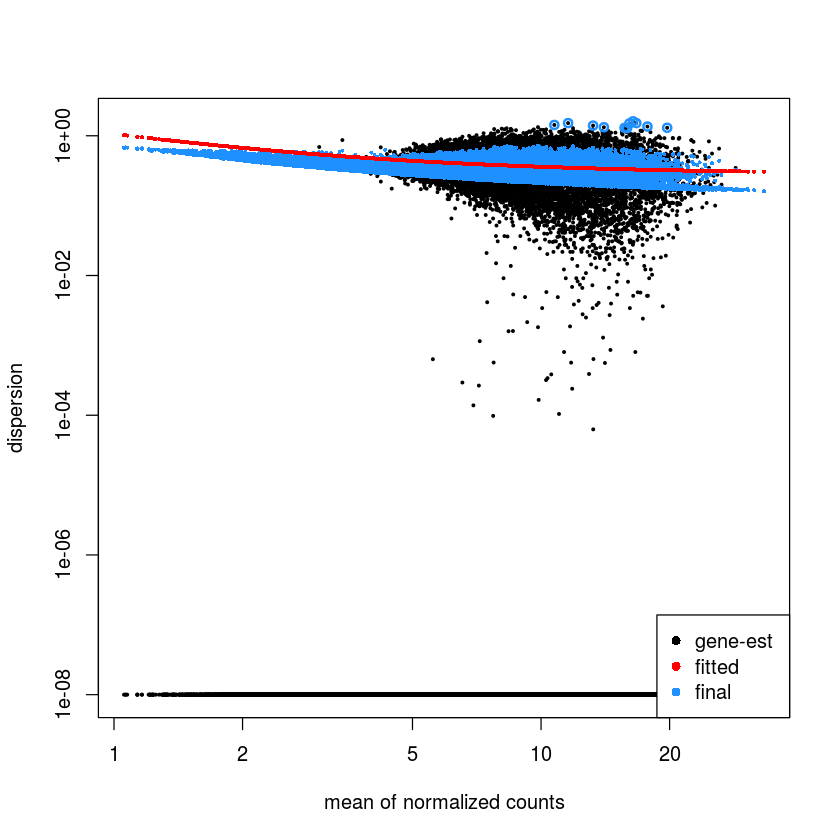

In [17]:
plotDispEsts(dds)


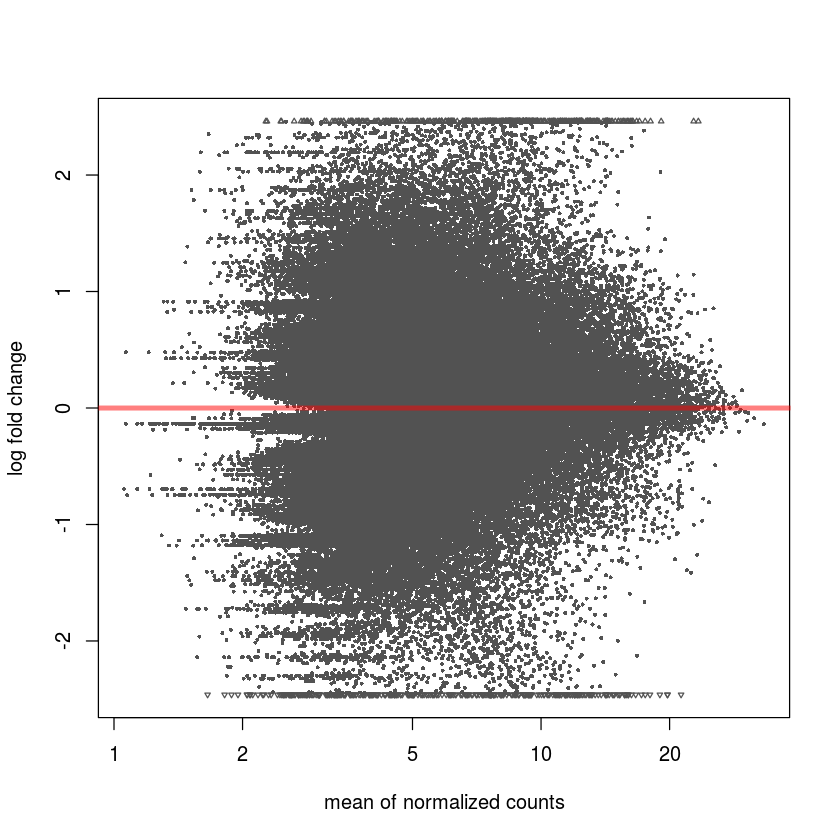

In [16]:
plotMA(dds)


## Standard BH Correction (no optimal thresholding) 

In [18]:
resultsNames(dds)

[1] "Intercept"                         "Timepoint_lateG1_vs_earlyG1"      
[3] "Timepoint_SG2M_vs_earlyG1"         "TimepointearlyG1.Treatmenttreated"
[5] "TimepointlateG1.Treatmenttreated"  "TimepointSG2M.Treatmenttreated"

In [19]:
res=results(dds)
summary(res)


out of 129441 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [37]:
namesToOutput=c("Timepoint_lateG1_vs_earlyG1",
"Timepoint_SG2M_vs_earlyG1",
"TimepointearlyG1.Treatmenttreated",
"TimepointlateG1.Treatmenttreated",
"TimepointSG2M.Treatmenttreated")
numcomparisons=length(namesToOutput)

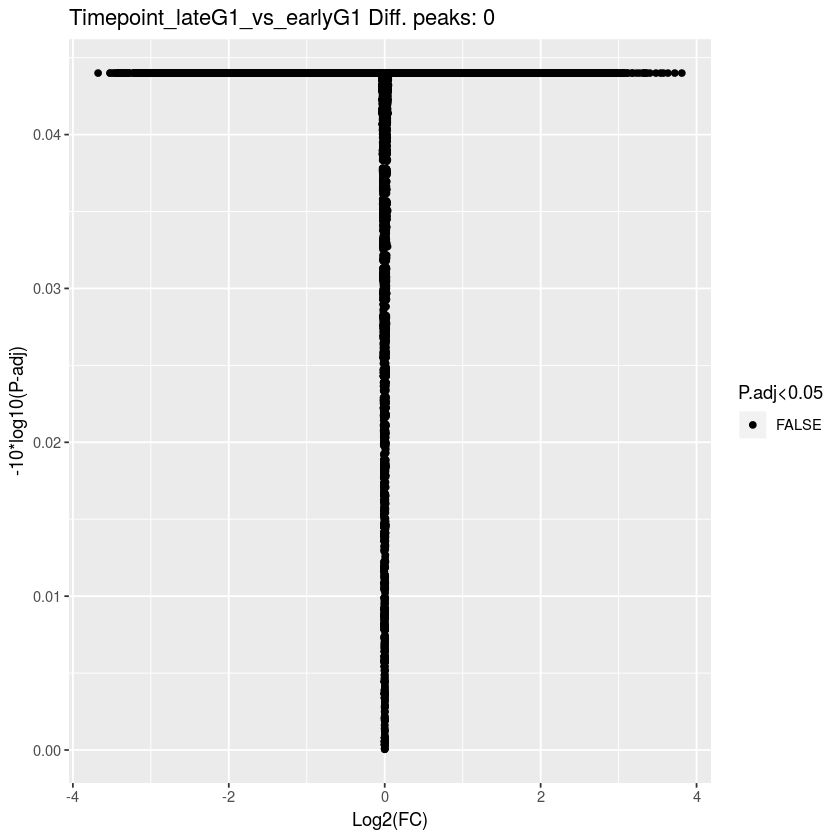

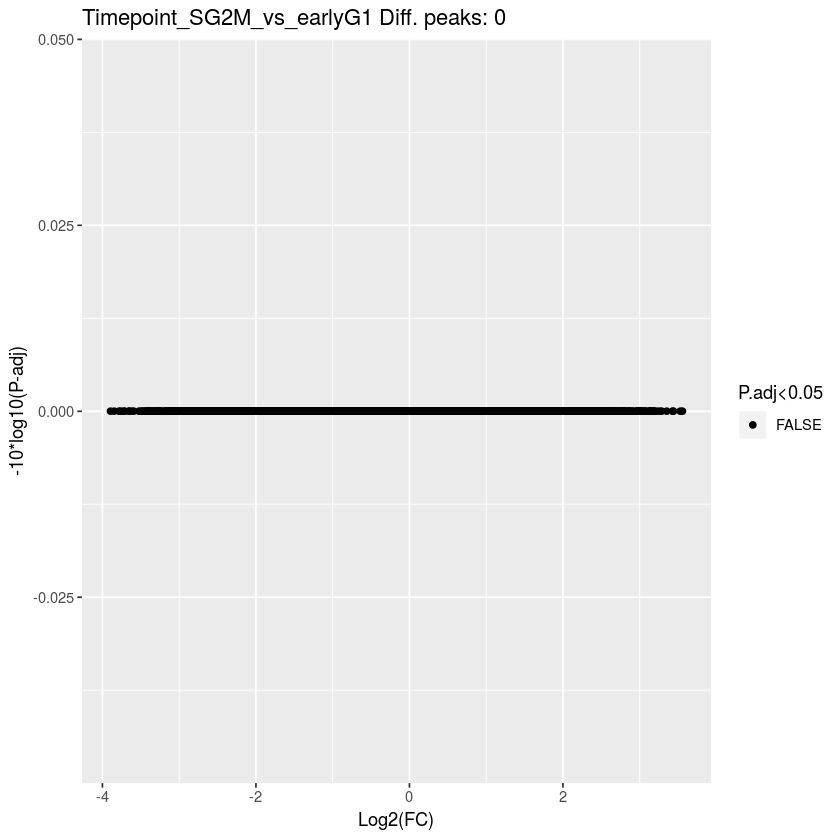

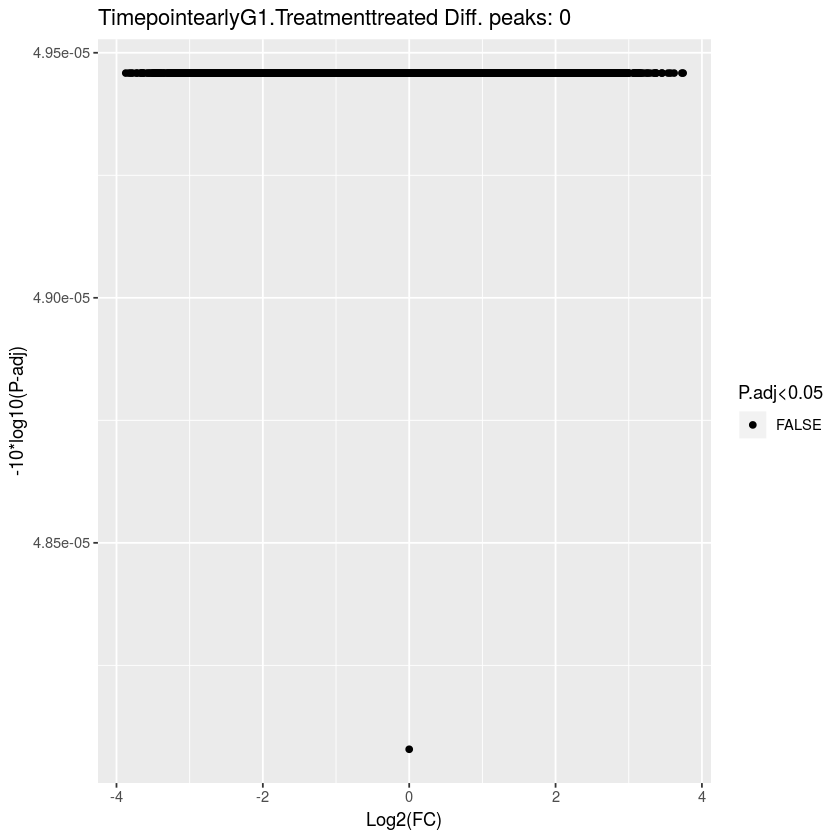

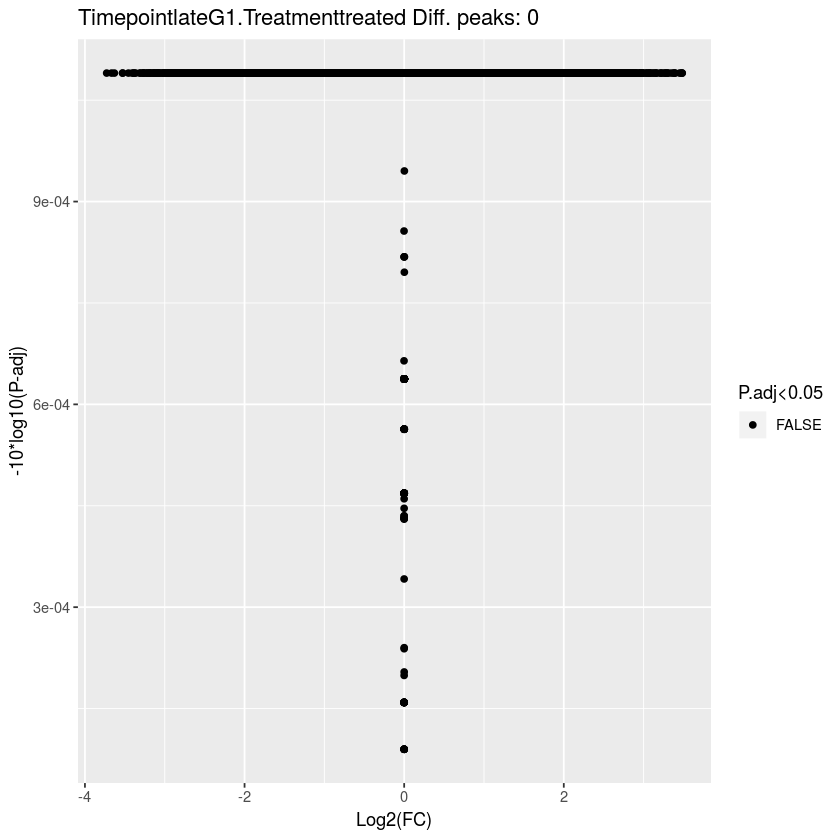

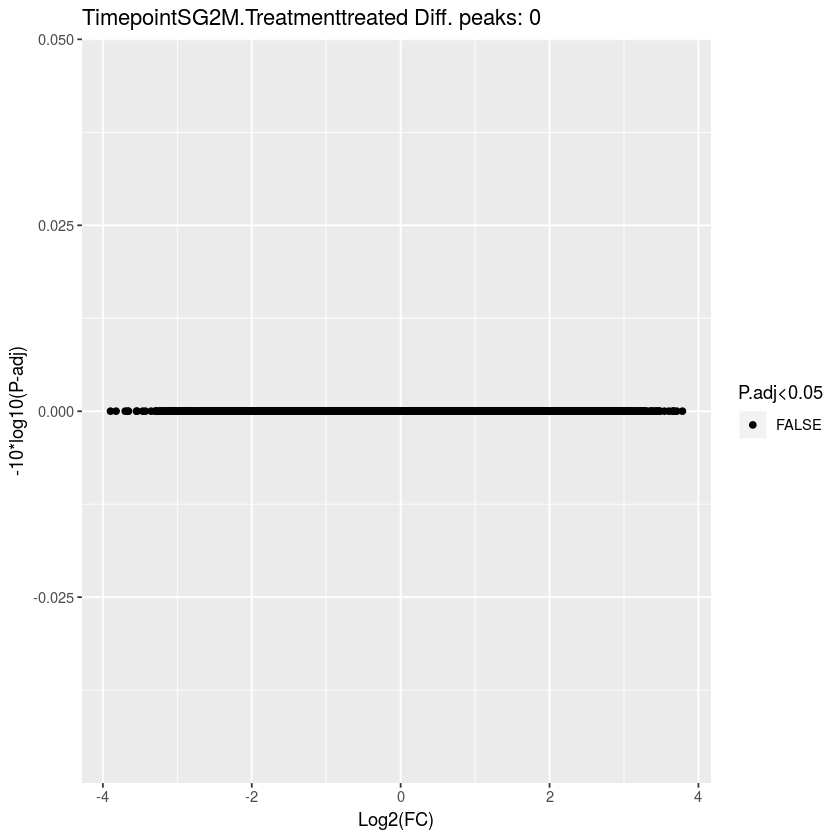

In [38]:
for(i in seq(1,numcomparisons))
{
 res=results(dds,name=namesToOutput[i],parallel=TRUE)
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 numsig=sum(res$padj <= 0.05)
 sigsubset=res[res$padj<=0.05,]

 #output differential analysis results for the contrast
 outtable=paste(namesToOutput[i],"tsv",sep='.')
 #write.table(sigsubset,file=outtable,quote=FALSE,sep='\t',row.names=TRUE,col.names=TRUE)

 #generate a volcano plot of the differential analysis for the contrast
 outpng=paste("volcano",namesToOutput[i],"png",sep='.')
 outlabel=paste(namesToOutput[i],"Diff. peaks:",numsig)
 res$color=res$padj<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$log2FoldChange,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
 #dev.off()
}


## Find an Optimal Filtering Threshold with -log10Pval v baseMean

In [23]:
res=results(dds)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

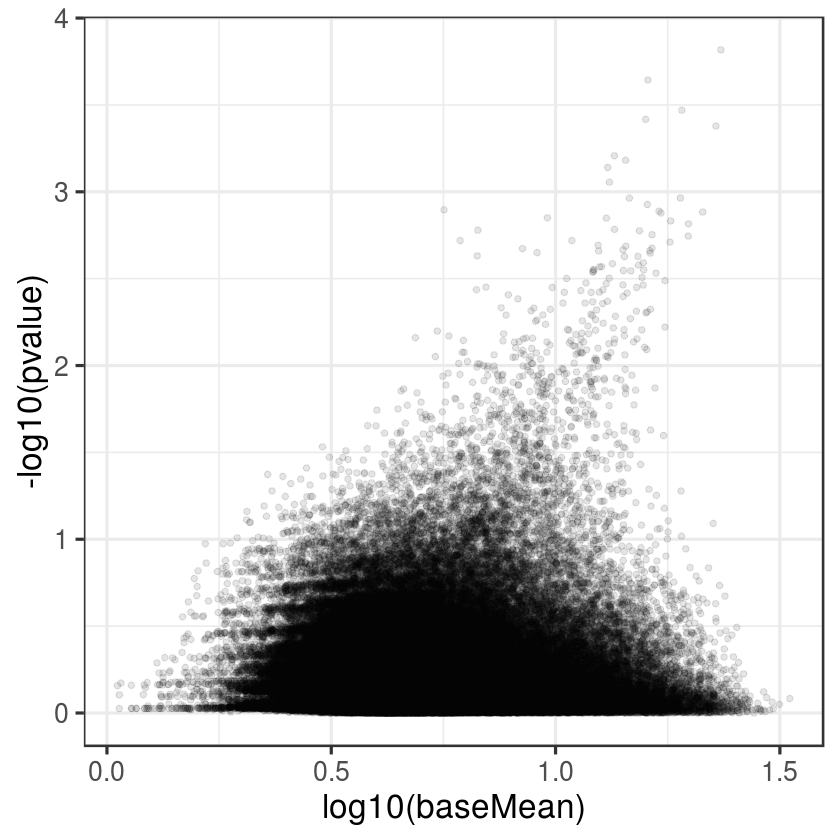

In [24]:
ggplot(data=res_df,
       aes(x=log10(res_df$baseMean),
           y=-log10(res_df$pvalue)))+
       geom_point(alpha=0.1)+
       xlab("log10(baseMean)")+
       ylab("-log10(pvalue)")+
       theme_bw(20)
       
       


## Find an optimal filtering threshold with IHW

In [25]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 129441 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [26]:
sum(resIHW$padj < 0.1, na.rm=TRUE)



[1] 0

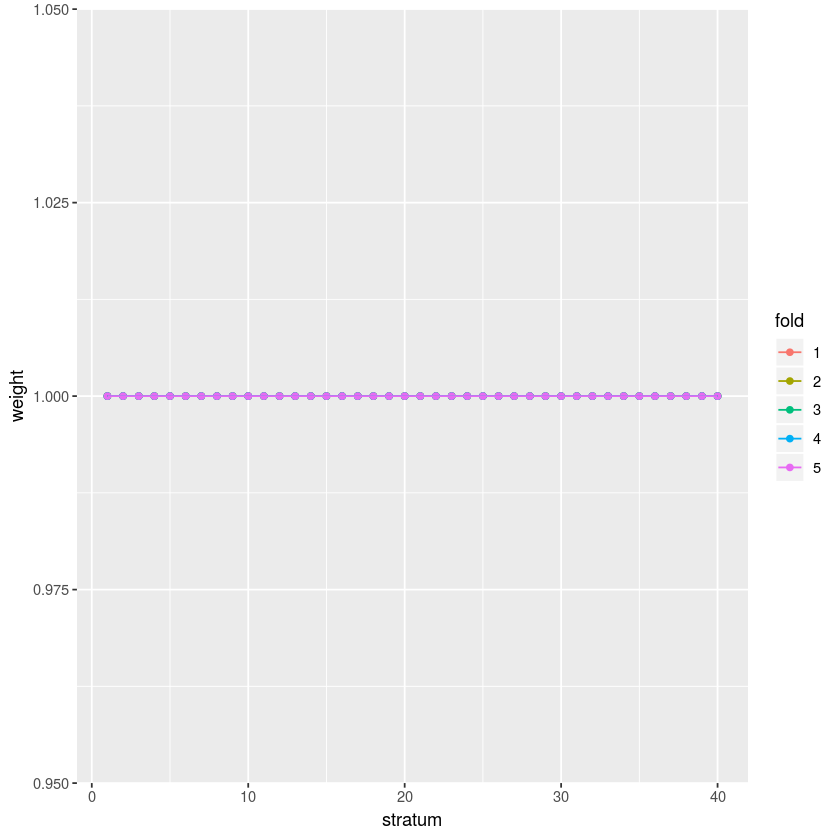

In [27]:
plot(metadata(resIHW)$ihwResult)



## Independent Filtering 

In [28]:
metadata(res)$alpha


[1] 0.1

In [29]:
metadata(res)$filterThreshold


0% 
1.055397

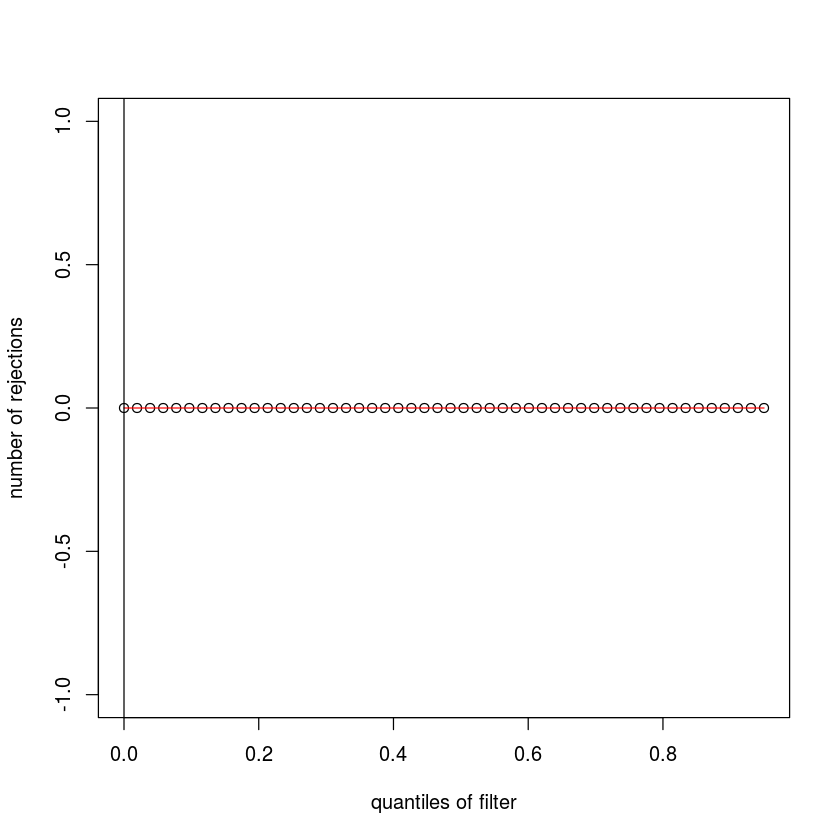

In [30]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [31]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,Sum
FALSE,129441,129441
Sum,129441,129441


In [32]:
summary(resNoFilt)


out of 129441 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

